In [20]:
from pydap.client import open_url
from datetime import datetime
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import pyproj
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import math
import pickle
from datetime import date
import os
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def get_plot_ticks(lat_values, long_values):

    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3

    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]

    return lat_list, long_list

def plot_wind(df ,interpolated = False):

    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['sp_lat'], df['sp_lon'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(np.sqrt(df['u10']**2 + df['v10']**2)), cmap='RdBu')
    bar = plt.colorbar()
    bar.ax.set_title('Wind Speed m/s')
    if interpolated:
        plt.title('Interpolated ERA5 Wind Speed')
    else:
        plt.title('ERA5 Wind Speed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('wind_speed.svg')
    plt.show()
    
def plot_var(df, var):

    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['sp_lat'], df['sp_lon'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(df[var]), cmap='RdBu')
    bar = plt.colorbar()
    bar.ax.set_title('db')
    plt.title(var)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('nbrcs-diff.svg')
    plt.show()
    
def generate_url(year, month, day, satellite_number):

    day_of_year = datetime(year, month, day).timetuple().tm_yday
    date_string = str(year) + str(month).zfill(2) + str(day).zfill(2)

    base_url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/cygnss/L1/v3.0/'
    specific_url = str(year) + '/' + str(day_of_year).zfill(3) + '/cyg0' + str(satellite_number) + '.ddmi.s' + \
                   date_string + '-000000-e' + date_string + '-235959.l1.power-brcs.a30.d31.nc'
    data_url = base_url + specific_url
    clickable_url = base_url + specific_url + '.html'

    return data_url + '?sp_lat,sp_lon,track_id,quality_flags,ddm_timestamp_utc,ddm_nbrcs,fresnel_coeff,sp_inc_angle', clickable_url

def fetch_cygnss(y1, m1, d1, y2, m2, d2):
    sdate = date(y1, m1, d1)   # start date
    edate = date(y2, m2, d2)   # end date
    delta = edate - sdate       # as timedelta
    df_list = []
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        df_list.append(get_cygnss_data(day.year, day.month, day.day))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)
    
def hours_since_ref(year, month, day):
    d0 = date(1992, 10, 5)
    d1 = date(year, month, day)
    delta = d1 - d0
    hours = delta.days*24
    return hours

def get_cygnss_data(year, month, day):
    cygnss_df = pd.DataFrame()
    hours = hours_since_ref(year, month, day)
    for sat_numb in range(1, 9): # Remember to change back to  1, 9
        print("Satellite number : " + str(sat_numb))
        test_data_url, test_clickable_url = generate_url(year, month, day, sat_numb)
        dataset = open_url(test_data_url, output_grid=False)
        for ddm in range(4):  # Remember to change back to 4
            ddm_df = pd.DataFrame()    
            print("ddm : " + str(ddm))
            
            ddm_timestamp_utc = np.array(dataset.ddm_timestamp_utc[:, ddm])
            ddm_timestamp_utc = np.rint(ddm_timestamp_utc/3600) + hours
            
            ddm_df['sp_lat'] = np.array(dataset.sp_lat[:, ddm]).tolist()
            ddm_df['sp_lon'] = np.array(dataset.sp_lon[:, ddm]).tolist()
            ddm_df['hours_since_ref'] = ddm_timestamp_utc.tolist()
            ddm_df['ddm_nbrcs'] = np.array(dataset.ddm_nbrcs[:, ddm]).tolist()
            ddm_df['fresnel_coeff'] = np.array(dataset.fresnel_coeff[:, ddm]).tolist()
            ddm_df['sp_inc_angle'] = np.array(dataset.sp_inc_angle[:, ddm]).tolist()
            ddm_df['quality_flags'] = np.array(dataset.quality_flags[:, ddm]).tolist()

            
            '''
            track_id = np.array(dataset.track_id[:, ddm])
            ddm_df['ddm_channel'] = np.zeros(len(sp_lon))
            ddm_df = ddm_df.assign(ddm_channel=ddm)
            ddm_df['track_id'] = track_id.tolist()            
            # ODD quality flagg means bad data, so should be dropped
            
            '''

            for col in ddm_df.columns:
                if col != 'ddm_channel' and col != 'hours_since_ref':
                    ddm_df[col] = ddm_df[col].apply(lambda x: x[0])
            cygnss_df = cygnss_df.append(ddm_df, ignore_index=True)
    return cygnss_df

def open_oskar_data_local(filename):
    ds = xr.open_dataset(filename)
    oskar_df = ds.to_dataframe()
    oskar_df.dropna(inplace = True)
    oskar_df = oskar_df.reset_index()
    d0 = date(1992, 10, 5)
    d1 = oskar_df['time'][1].date()
    delta = d1 - d0
    hours = delta.days*24
    oskar_df['time'] = np.zeros(len(oskar_df['time']))
    oskar_df = oskar_df.assign(time=hours)
    oskar_df = oskar_df.rename(columns={"latitude": "sp_lat", "longitude": "sp_lon", "time" : "hours_since_ref"})
    oskar_df = oskar_df.loc[oskar_df['sp_lon'] < 380 ]
    oskar_df['sp_lon'] = oskar_df['sp_lon']%360
    oskar_df = reduce_area_of_df(oskar_df)
    return oskar_df

def fetch_all_oskar_files():
    df_list = []
    for filename in os.listdir('oskar_data'):
        df_list.append(open_oskar_data_local('oskar_data/' + filename))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)
    

In [2]:
# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 9.5]
    df = df[df.sp_lat >= -10]
    df = df[df.sp_lon >= 200]
    return df[df.sp_lon <= 210]

oskar_df = fetch_all_oskar_files()
oskar_df

hours_since_ref     sp_lat      sp_lon  depth         u         v
123962           253992   9.333333  200.000000   15.0  0.100953 -0.009289
123963           253992   9.333333  200.333333   15.0  0.077290  0.003463
123964           253992   9.333333  200.666667   15.0  0.071818 -0.002268
123965           253992   9.333333  201.000000   15.0  0.054943 -0.014659
123966           253992   9.333333  201.333333   15.0  0.017294 -0.020006
...                 ...        ...         ...    ...       ...       ...
173724           254232 -10.000000  208.666667   15.0 -0.167086 -0.049265
173725           254232 -10.000000  209.000000   15.0 -0.191863 -0.058952
173726           254232 -10.000000  209.333333   15.0 -0.208142 -0.084709
173727           254232 -10.000000  209.666667   15.0 -0.217126 -0.104064
173728           254232 -10.000000  210.000000   15.0 -0.213702 -0.104521

[5481 rows x 6 columns]

In [30]:
read = True
if read:
    cygnss_df = pd.read_pickle('df.pkl')
else:
    cygnss_df = fetch_cygnss(2021, 10, 1, 2021, 10, 1)
    cygnss_df.to_pickle('df.pkl')

cygnss_df

sp_lat      sp_lon  hours_since_ref    ddm_nbrcs  fresnel_coeff  \
0       -16.354046  347.556946         254112.0    27.587561       0.683440   
1       -16.338102  347.580353         254112.0    27.114931       0.683447   
2       -16.322159  347.603729         254112.0    27.290983       0.683454   
3       -16.306217  347.627136         254112.0    26.335760       0.683461   
4       -16.290274  347.650513         254112.0    26.723040       0.683468   
...            ...         ...              ...          ...            ...   
5512627  28.005102   65.349808         254136.0 -9999.000000       0.654564   
5512628  28.011261   65.379822         254136.0 -9999.000000       0.654573   
5512629  28.017397   65.409851         254136.0 -9999.000000       0.654581   
5512630  28.023512   65.439873         254136.0 -9999.000000       0.654590   
5512631  28.029606   65.469902         254136.0 -9999.000000       0.654599   

         sp_inc_angle  quality_flags  
0           28.428041          65537  
1           28.418032          65537  
2           28.408052          65537  
3           28.398088          65537  
4           28.388163          65537  
...               ...            ...  
5512627     53.053688         269313  
5512628     53.048660         269313  
5512629     53.043629         269313  
5512630     53.038605         269313  
5512631     53.033569         269313  

[5512632 rows x 7 columns]

In [31]:
np.warnings.filterwarnings('ignore')
for key in cygnss_df:
    cygnss_df = cygnss_df[cygnss_df[key] != -9999.0]
cygnss_df = cygnss_df[cygnss_df.quality_flags%2 == 0]
cygnss_df.dropna(inplace = True)
cygnss_df['nbrcs_log'] = 10*np.log10(cygnss_df.ddm_nbrcs.to_numpy())
cygnss_df.drop('ddm_nbrcs', inplace=True, axis=1)
cygnss_df = reduce_area_of_df(cygnss_df)

cygnss_df

sp_lat      sp_lon  hours_since_ref  fresnel_coeff  sp_inc_angle  \
68566   -2.933609  202.195221         254122.0       0.585046     67.940628   
68567   -2.917802  202.218216         254122.0       0.585061     67.938751   
68568   -2.902014  202.241211         254122.0       0.585075     67.936897   
68569   -2.886207  202.264191         254122.0       0.585089     67.935020   
68570   -2.870396  202.287170         254122.0       0.585103     67.933159   
...           ...         ...              ...            ...           ...   
5333369 -3.197981  208.420013         254135.0       0.614637     63.860752   
5333370 -3.213227  208.442902         254135.0       0.614603     63.866161   
5333371 -3.228484  208.465790         254135.0       0.614569     63.871593   
5333372 -3.243722  208.488678         254135.0       0.614535     63.877010   
5333373 -3.258991  208.511566         254135.0       0.614501     63.882473   

         quality_flags  nbrcs_log  
68566          1048576  12.997142  
68567                0  13.760593  
68568                0  14.518236  
68569          1048576  14.761988  
68570                0  14.651203  
...                ...        ...  
5333369        1048576  15.212752  
5333370              0  14.717713  
5333371              0  14.265456  
5333372        1048576  15.327811  
5333373        1048576  14.150738  

[18692 rows x 7 columns]

In [32]:
#ds = xr.open_dataset('adaptor.mars.internal-1636460051.1656115-15503-16-d4e7e8a4-eb23-4930-9ae5-def374c3fe95.nc')
ds = xr.open_dataset('hele_verden_1_okt.nc')
era_5_df = ds.to_dataframe()
index_long = era_5_df.index.levels[0]
index_lat = era_5_df.index.levels[1]
index_time = era_5_df.index.levels[2]

start_time = pd.Timestamp(1992, 10, 5)
index_time_fixed = []
for tid in index_time:
    hours = tid - start_time
    index_time_fixed.append(hours.days*24 + hours.seconds/3600)

long, lat, time = np.meshgrid(index_long, index_lat, index_time_fixed, indexing = 'ij')

long = long.flatten()
lat = lat.flatten()
time = time.flatten()

era_5_df = pd.DataFrame({'sp_lon': long, 'sp_lat' :lat, 'hours_since_ref': time, 'u10': era_5_df["u10"].to_numpy()
            ,'v10': era_5_df["v10"].to_numpy()})
era_5_df = reduce_area_of_df(era_5_df)
era_5_df

sp_lon  sp_lat  hours_since_ref       u10       v10
13850928   200.0     9.5         254112.0 -3.505194  3.381651
13850929   200.0     9.5         254113.0 -3.053865  3.340508
13850930   200.0     9.5         254114.0 -2.894907  2.873244
13850931   200.0     9.5         254115.0 -2.468178  2.413817
13850932   200.0     9.5         254116.0 -2.191893  1.877003
...          ...     ...              ...       ...       ...
14544979   210.0   -10.0         254131.0 -8.444265  0.311621
14544980   210.0   -10.0         254132.0 -7.875610  0.203866
14544981   210.0   -10.0         254133.0 -7.430904  0.352764
14544982   210.0   -10.0         254134.0 -7.462128  1.067863
14544983   210.0   -10.0         254135.0 -7.587024  1.022802

[77736 rows x 5 columns]

In [33]:
interp_u10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['u10'])
print("done")
interp_v10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['v10'])

done


In [34]:
lons_to_interpolate = cygnss_df["sp_lon"].to_numpy()
lats_to_interpolate = cygnss_df["sp_lat"].to_numpy()
times_to_interpolate = cygnss_df["hours_since_ref"].to_numpy()

u10 = interp_u10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)
v10 = interp_v10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)

In [35]:
cygnss_and_interp_df = pd.DataFrame({'sp_lon': lons_to_interpolate, 'sp_lat' :lats_to_interpolate, 'hours_since_ref': times_to_interpolate, 'u10': u10, 'v10': v10, 'nbrcs_log' : cygnss_df['nbrcs_log'], 'fresnel_coeff' : cygnss_df['fresnel_coeff'], 'sp_inc_angle' : cygnss_df['sp_inc_angle']  })
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.185357  0.992041  12.997142   
68567    202.218216 -2.917802         254122.0 -8.185373  0.988584  13.760593   
68568    202.241211 -2.902014         254122.0 -8.185387  0.985131  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183954  0.982507  14.761988   
68570    202.287170 -2.870396         254122.0 -8.181623  0.980400  14.651203   
...             ...       ...              ...       ...       ...        ...   
5333369  208.420013 -3.197981         254135.0 -7.063450 -0.530971  15.212752   
5333370  208.442902 -3.213227         254135.0 -7.054670 -0.543672  14.717713   
5333371  208.465790 -3.228484         254135.0 -7.045892 -0.556376  14.265456   
5333372  208.488678 -3.243722         254135.0 -7.037110 -0.569074  15.327811   
5333373  208.511566 -3.258991         254135.0 -7.024966 -0.579104  14.150738   

         fresnel_coeff  sp_inc_angle  
68566         0.585046     67.940628  
68567         0.585061     67.938751  
68568         0.585075     67.936897  
68569         0.585089     67.935020  
68570         0.585103     67.933159  
...                ...           ...  
5333369       0.614637     63.860752  
5333370       0.614603     63.866161  
5333371       0.614569     63.871593  
5333372       0.614535     63.877010  
5333373       0.614501     63.882473  

[18692 rows x 8 columns]

In [36]:
interp_u = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['u'])
print("done")
interp_v = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['v'])

done


In [37]:
lons_to_interpolate = cygnss_df["sp_lon"].to_numpy()
lats_to_interpolate = cygnss_df["sp_lat"].to_numpy()
times_to_interpolate = cygnss_df["hours_since_ref"].to_numpy()

u_current = interp_u(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)
v_current = interp_v(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)

cygnss_and_interp_df['u_current'] = u_current
cygnss_and_interp_df['v_current'] = v_current
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.185357  0.992041  12.997142   
68567    202.218216 -2.917802         254122.0 -8.185373  0.988584  13.760593   
68568    202.241211 -2.902014         254122.0 -8.185387  0.985131  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183954  0.982507  14.761988   
68570    202.287170 -2.870396         254122.0 -8.181623  0.980400  14.651203   
...             ...       ...              ...       ...       ...        ...   
5333369  208.420013 -3.197981         254135.0 -7.063450 -0.530971  15.212752   
5333370  208.442902 -3.213227         254135.0 -7.054670 -0.543672  14.717713   
5333371  208.465790 -3.228484         254135.0 -7.045892 -0.556376  14.265456   
5333372  208.488678 -3.243722         254135.0 -7.037110 -0.569074  15.327811   
5333373  208.511566 -3.258991         254135.0 -7.024966 -0.579104  14.150738   

         fresnel_coeff  sp_inc_angle  u_current  v_current  
68566         0.585046     67.940628  -0.363265  -0.174035  
68567         0.585061     67.938751  -0.362987  -0.171106  
68568         0.585075     67.936897  -0.362711  -0.167713  
68569         0.585089     67.935020  -0.362447  -0.161729  
68570         0.585103     67.933159  -0.362183  -0.155745  
...                ...           ...        ...        ...  
5333369       0.614637     63.860752  -0.508840  -0.207108  
5333370       0.614603     63.866161  -0.509855  -0.209702  
5333371       0.614569     63.871593  -0.513169  -0.210147  
5333372       0.614535     63.877010  -0.517360  -0.209773  
5333373       0.614501     63.882473  -0.521552  -0.209397  

[18692 rows x 10 columns]

In [38]:
diff_u = cygnss_and_interp_df['u10']-cygnss_and_interp_df['u_current']
diff_v = cygnss_and_interp_df['v10']-cygnss_and_interp_df['v_current']
delta = np.sqrt(diff_u**2 + diff_v**2)

top_frac = 0.059*delta**3 - 0.147*delta**2 + 0.903**delta + 1.389
bot_frac = delta**3 + 18.161*delta**2 - 117.602*delta + 706.9
mss_from_wind_current = top_frac/bot_frac
fresnell_sqrd = cygnss_and_interp_df['fresnel_coeff'].to_numpy()**2

bias_df = pd.read_csv ('bias_model.csv')
interp_bias = LinearNDInterpolator(list(zip(bias_df['inc_angle'], bias_df['delta'])), bias_df['bias'])
biases = interp_bias(cygnss_and_interp_df['sp_inc_angle'], delta)
predicted_nbrcs = 10*np.log10(fresnell_sqrd/mss_from_wind_current) + biases

mss_from_cygnss = fresnell_sqrd/(10**((cygnss_and_interp_df['nbrcs_log'] - biases)/10))

In [39]:
# CYGNSS - CURRENT AND WIND ESTIMATIONS
cygnss_and_interp_df['diff_nbrcs'] = cygnss_and_interp_df['nbrcs_log'] - predicted_nbrcs
cygnss_and_interp_df['diff_mss'] = mss_from_cygnss - mss_from_wind_current
cygnss_and_interp_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
68566    202.195221 -2.933609         254122.0 -8.185357  0.992041  12.997142   
68567    202.218216 -2.917802         254122.0 -8.185373  0.988584  13.760593   
68568    202.241211 -2.902014         254122.0 -8.185387  0.985131  14.518236   
68569    202.264191 -2.886207         254122.0 -8.183954  0.982507  14.761988   
68570    202.287170 -2.870396         254122.0 -8.181623  0.980400  14.651203   
...             ...       ...              ...       ...       ...        ...   
5333369  208.420013 -3.197981         254135.0 -7.063450 -0.530971  15.212752   
5333370  208.442902 -3.213227         254135.0 -7.054670 -0.543672  14.717713   
5333371  208.465790 -3.228484         254135.0 -7.045892 -0.556376  14.265456   
5333372  208.488678 -3.243722         254135.0 -7.037110 -0.569074  15.327811   
5333373  208.511566 -3.258991         254135.0 -7.024966 -0.579104  14.150738   

         fresnel_coeff  sp_inc_angle  u_current  v_current  diff_nbrcs  \
68566         0.585046     67.940628  -0.363265  -0.174035   -1.079500   
68567         0.585061     67.938751  -0.362987  -0.171106   -0.316798   
68568         0.585075     67.936897  -0.362711  -0.167713    0.440045   
68569         0.585089     67.935020  -0.362447  -0.161729    0.681589   
68570         0.585103     67.933159  -0.362183  -0.155745    0.567930   
...                ...           ...        ...        ...         ...   
5333369       0.614637     63.860752  -0.508840  -0.207108   -0.416777   
5333370       0.614603     63.866161  -0.509855  -0.209702   -0.921875   
5333371       0.614569     63.871593  -0.513169  -0.210147   -1.386450   
5333372       0.614535     63.877010  -0.517360  -0.209773   -0.337356   
5333373       0.614501     63.882473  -0.521552  -0.209397   -1.531649   

         diff_mss  
68566    0.004376  
68567    0.001173  
68568   -0.001494  
68569   -0.002251  
68570   -0.001899  
...           ...  
5333369  0.001233  
5333370  0.002890  
5333371  0.004586  
5333372  0.000982  
5333373  0.005125  

[18692 rows x 12 columns]

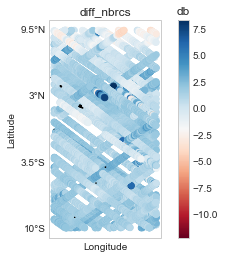

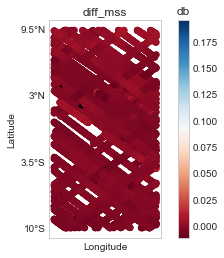

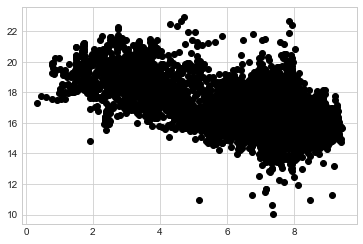

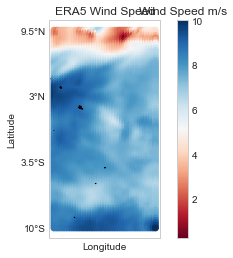

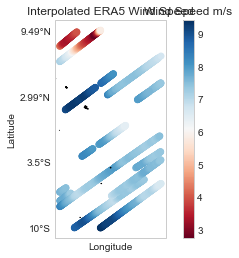

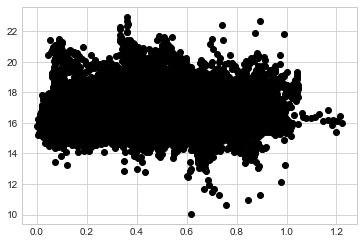

In [40]:
if True:
    plot_var(cygnss_and_interp_df,'diff_nbrcs' )
    plot_var(cygnss_and_interp_df,'diff_mss' )
    plot_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_interp_df['nbrcs_log'], 'Wind_Speed' : np.sqrt(cygnss_and_interp_df['u10']**2+cygnss_and_interp_df['v10']**2)})
    plot_df = plot_df[plot_df.NBRCS_LOG_SCALED > 10]
    plot_df = plot_df[plot_df.NBRCS_LOG_SCALED < 23]
    plot_df = plot_df[plot_df.Wind_Speed > 0.5]

    fig = px.density_heatmap(plot_df, y="NBRCS_LOG_SCALED", x="Wind_Speed",  color_continuous_scale=px.colors.sequential.Blackbody  ,title="2D Histogram plot of Wind speed and NBRCS in DB scale")

    fig.show()

    plt.style.use('seaborn-whitegrid')
    plt.plot((plot_df['Wind_Speed'].to_numpy()), (plot_df['NBRCS_LOG_SCALED'].to_numpy()), 'o', color='black');
    
    plt.show()

    era_5_df_one_hour = era_5_df.loc[(era_5_df['hours_since_ref'] == 254122)]
    cygnss_and_wind_df_one_hour = cygnss_and_interp_df.loc[(cygnss_and_interp_df['hours_since_ref'] == 254122)]

    plot_wind(era_5_df_one_hour)
    plot_wind(cygnss_and_wind_df_one_hour, interpolated= True)

    plot_current_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_interp_df['nbrcs_log'], 'Ocean_current_speed_15_meters_depth' : np.sqrt(cygnss_and_interp_df['u_current']**2+cygnss_and_interp_df['v_current']**2)})
    plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED > 10]
    plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED < 23]
    #plot_current_df = plot_current_df[plot_current_df.Ocean_current_speed_15_meters_depth < 1.1]
    fig = px.density_heatmap(plot_current_df, y="NBRCS_LOG_SCALED", x="Ocean_current_speed_15_meters_depth", title="2D Histogram plot of Ocean current strength at 15 meters depth and NBRCS in DB scale", color_continuous_scale=px.colors.sequential.Blackbody)
    fig.show()

    plt.style.use('seaborn-whitegrid')
    plt.plot((plot_current_df['Ocean_current_speed_15_meters_depth'].to_numpy()), (plot_current_df['NBRCS_LOG_SCALED'].to_numpy()), 'o', color='black');
    
    plt.show()
    cygnss_and_wind_df_one_hour['total_wind'] = np.sqrt(cygnss_and_wind_df_one_hour['u10']**2 + cygnss_and_wind_df_one_hour['v10']**2)

    fig = px.density_mapbox(cygnss_and_wind_df_one_hour, lat='sp_lat', lon='sp_lon', z='total_wind', radius=10,
                            center=dict(lat=0, lon=180), zoom=0,
                            mapbox_style="stamen-terrain")
    fig.show()